In [ ]:
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet("data/journeys_flattened.parquet")

In [3]:
df['isSuccessful'] = [28 in events for events in df['events']]

In [4]:
df.head()

,customer_id,account_id,events,timestamps,journey_length,isSuccessful
0,937521598,-1666588647,"[2, 12, 4, 4, 1, 1, 21, 1, 1, 1, 1, 1, 1]","[2021-02-06T06:00:00.000000, 2021-02-06T08:20:...",13,False
1,-2007336810,1205421894,"[12, 19, 19, 19, 19, 19, 4, 4, 4, 4, 1, 5, 4, ...","[2021-03-11T00:28:02.000000, 2021-03-11T00:29:...",26,False
2,1089556213,237330854,"[15, 24, 29, 18, 24, 27, 28]","[2021-02-23T12:21:55.000000, 2021-02-27T14:37:...",7,True
3,128891967,-965789906,"[12, 4, 4, 4, 24, 1, 21, 1, 1, 1, 21, 1]","[2021-04-08T16:31:44.000000, 2021-04-08T16:33:...",12,False
4,1747551427,-721322194,"[21, 1, 22, 2, 12, 4, 11, 4, 4, 4, 5, 24, 1, 1...","[2021-11-12T00:00:00.000000, 2021-11-12T05:07:...",20,False


In [5]:
# About 99.5% of successful journeys end with the order_shipped event
np.mean([events[-1] == 28 for events in df.loc[df['isSuccessful'], 'events']])

np.float64(0.9950888270816106)

In [6]:
# 1372 successful journeys have at least one other event after the order has shipped (indicating journey success)
len(np.where([events[-1] != 28 for events in df.loc[df['isSuccessful'], 'events']])[0])

1372

In [7]:
successfulJourneys = df[df['isSuccessful']].copy().reset_index(drop=True)
unsuccessfulJourneys = df[~df['isSuccessful']].copy().reset_index(drop=True)

In [48]:
successfulJourneys['first_event'] = [events[0] for events in successfulJourneys['events']]

In [53]:
first_event_counts = Counter(successfulJourneys['first_event'])

In [226]:
events = pd.read_csv("data/Event Definitions.csv")

In [227]:
events.head()

,event_name,journey_id,event_definition_id,milestone_number,stage
0,application_phone_approved,1,15,1.0,Apply for Credit
1,application_phone_declined,1,16,NaN,Apply for Credit
2,application_phone_pending,1,17,NaN,Apply for Credit
3,application_web_approved,1,12,1.0,Apply for Credit
4,application_web_declined,1,13,NaN,Apply for Credit


In [228]:
events['num_first_events_successful'] = [first_event_counts.get(event_id, 0) for event_id in events['event_definition_id']]

In [229]:
events['stage'].unique()

array(['Apply for Credit', 'Credit Account', 'Discover', 'Downpayment',
       'First Purchase', 'Order Shipped', 'Prospecting'], dtype=object)

In [230]:
events.loc[events['num_first_events_successful'] > 0, 'stage'].unique()

array(['Apply for Credit', 'Credit Account', 'Discover', 'Downpayment',
       'First Purchase', 'Order Shipped', 'Prospecting'], dtype=object)

In [265]:
first_stages_successful = events.loc[events['num_first_events_successful'] > 0, ['stage', 'num_first_events_successful']].groupby('stage')['num_first_events_successful'].sum().sort_values(ascending=False).reset_index()
first_stages_successful['prop_first_events'] = first_stages_successful['num_first_events_successful'] / first_stages_successful['num_first_events_successful'].sum()
first_stages_successful

,stage,num_first_events_successful,prop_first_events
0,Apply for Credit,107857,0.401730
1,Discover,97810,0.364309
2,Credit Account,37591,0.140014
3,First Purchase,15805,0.058868
4,Prospecting,9381,0.034941
5,Order Shipped,35,0.000130
6,Downpayment,2,0.000007


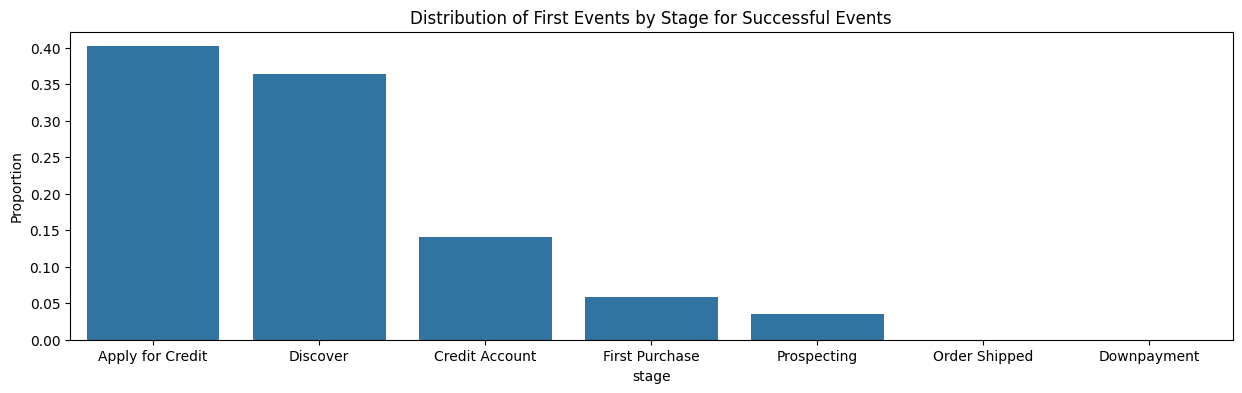

In [267]:
plt.figure(figsize=(15, 4))
sns.barplot(data=first_stages_successful, x='stage', y='prop_first_events')
plt.title('Distribution of First Events by Stage for Successful Events')
plt.ylabel('Proportion')
plt.show()

It looks like journeys can start in any stage, but the vast majority start in applying for credit (associated with milestone 1), discover (no stage association), credit account (associated with stage 3), first purchase (associated with stage 2), and prospecting (no stage association)

There are two starting events that are found in the dataset but not defined in the events definition (`event_definition_id` 1 and 24)

In [234]:
unsuccessfulJourneys['first_event'] = [events[0] for events in unsuccessfulJourneys['events']]

In [235]:
first_event_counts_unsuccessful = Counter(unsuccessfulJourneys['first_event'])

In [ ]:
first_event_counts_unsuccessful

Counter({2: 402264,
         12: 316146,
         19: 201176,
         4: 46998,
         21: 43783,
         22: 37139,
         1: 30027,
         15: 17938,
         29: 16291,
         3: 9161,
         6: 8718,
         13: 7801,
         5: 7617,
         24: 4990,
         20: 370,
         23: 276,
         16: 198,
         11: 140,
         18: 26,
         8: 9,
         7: 8,
         14: 4,
         10: 2})

In [236]:
events['num_first_events_unsuccessful'] = [first_event_counts_unsuccessful.get(event_id, 0) for event_id in events['event_definition_id']]

In [238]:
events.loc[events['num_first_events_unsuccessful'] > 0, 'stage'].unique()

array(['Apply for Credit', 'Credit Account', 'Discover', 'Downpayment',
       'First Purchase', 'Prospecting'], dtype=object)

Unsuccessful journeys can also start in any stage (except of course, Order Shipped)

In [264]:
first_stages_unsuccessful = events.loc[events['num_first_events_unsuccessful'] > 0, ['stage', 'num_first_events_unsuccessful']].groupby('stage')['num_first_events_unsuccessful'].sum().sort_values(ascending=False).reset_index()
first_stages_unsuccessful['prop_first_events'] = first_stages_unsuccessful['num_first_events_unsuccessful'] / first_stages_unsuccessful['num_first_events_unsuccessful'].sum()
first_stages_unsuccessful

,stage,num_first_events_unsuccessful,prop_first_events
0,Apply for Credit,552424,0.494975
1,Discover,439681,0.393956
2,First Purchase,63507,0.056903
3,Prospecting,44153,0.039561
4,Credit Account,16291,0.014597
5,Downpayment,9,0.000008


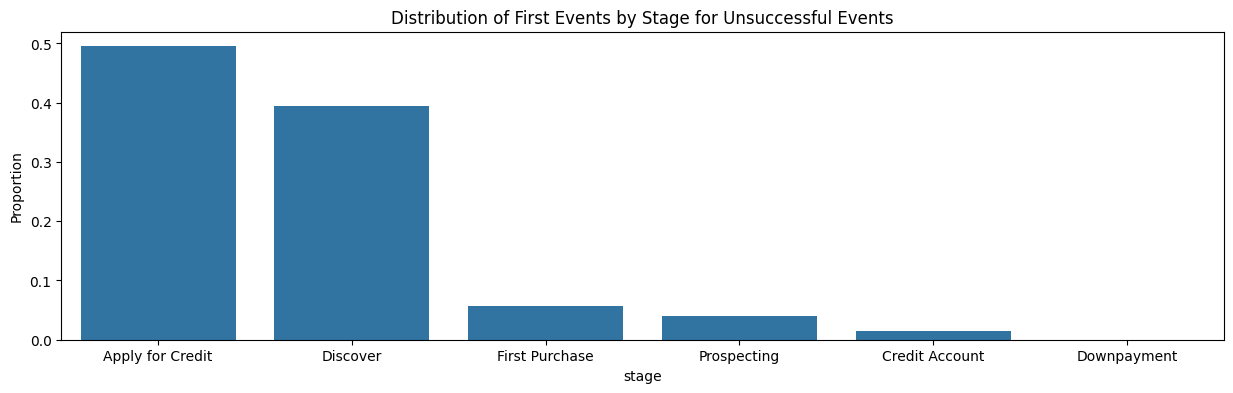

In [268]:
plt.figure(figsize=(15, 4))
sns.barplot(data=first_stages_unsuccessful, x='stage', y='prop_first_events')
plt.title('Distribution of First Events by Stage for Unsuccessful Events')
plt.ylabel('Proportion')
plt.show()

## Stages Completed for Successful Events

### Milestone 1: Credit Application Approval

Nearly all (99.9%) successful journeys go through the credit approval milestone. The vast majority (96.3% out of 99.9%) come from web applications while only a small portion (3.66% out of 99.9%) come from phone applications. There are a very small proportion of journeys (less than 1%) in which users got approved both online and over the phone.

#### Successful Journeys

In [110]:
# Credit approved from either method
100 * np.mean([(12 in events) or (15 in events) for events in successfulJourneys['events']])

np.float64(99.93699953107605)

In [111]:
# Event 12: Web Application Approval
100 * np.mean([12 in events for events in successfulJourneys['events']])

np.float64(96.2947849214105)

In [ ]:
# Event 15: Phone Application Approval
100 * np.mean([15 in events for events in successfulJourneys['events']])

np.float64(3.659038598525932)

In [106]:
100 * np.mean([(12 in events) and (15 in events) for events in successfulJourneys['events']])

np.float64(0.01682398886037163)

#### Unsuccessful Journeys

We see very similar numbers from unsuccessful journeys, so this doesn't help us distinguish between whether or not we expect a user to have a successful journey.

In [120]:
# Credit approved from either method
100 * np.mean([(12 in events) or (15 in events) for events in unsuccessfulJourneys['events']])

np.float64(99.79940612397726)

In [121]:
# Event 12: Web Application Approval
100 * np.mean([12 in events for events in unsuccessfulJourneys['events']])

np.float64(97.45300508564985)

In [122]:
# Event 15: Phone Application Approval
100 * np.mean([15 in events for events in unsuccessfulJourneys['events']])

np.float64(2.3522216488486487)

In [123]:
100 * np.mean([(12 in events) and (15 in events) for events in unsuccessfulJourneys['events']])

np.float64(0.005820610521231328)

### Milestone 2: Placing an Order

Nearly all (98.3%) successful journeys place an order. The vast majority (90.3% out of 98.3%) come from web applications while only a small portion (10.5% out of 98.3%) come from phone applications. There is a small proportion of journeys (about 2.4%) in which users placed an order both online and over the phone.

#### Successful Journeys

In [124]:
# Order placed from either method
100 * np.mean([(7 in events) or (18 in events) for events in successfulJourneys['events']])

np.float64(98.32010681443141)

In [125]:
# Event 12: Web Order Placed
100 * np.mean([7 in events for events in successfulJourneys['events']])

np.float64(90.2678593800897)

In [126]:
# Event 15: Phone Order Placed
100 * np.mean([18 in events for events in successfulJourneys['events']])

np.float64(10.452708483227916)

In [127]:
100 * np.mean([(7 in events) and (18 in events) for events in successfulJourneys['events']])

np.float64(2.4004610488862164)

#### Unsuccessful Journeys

In contrast, only about 5% of unsuccessful journeys actually placed an order. This indicates that most unsuccessful journeys (about 95%) never reach this milestone. Therefore, if we see in a journey that a user was able to place an order, there is a much higher probability that their journey was successful.

In [132]:
# Order placed from either method
100 * np.mean([(7 in events) or (18 in events) for events in unsuccessfulJourneys['events']])

np.float64(5.323686757329192)

In [133]:
# Event 12: Web Order Placed
100 * np.mean([7 in events for events in unsuccessfulJourneys['events']])

np.float64(3.5014012902642904)

In [134]:
# Event 15: Phone Order Placed
100 * np.mean([18 in events for events in unsuccessfulJourneys['events']])

np.float64(1.8793622000865273)

In [135]:
100 * np.mean([(7 in events) and (18 in events) for events in unsuccessfulJourneys['events']])

np.float64(0.057076733021626615)

### Milestone 3: Account Activation

Nearly all (99.6%) successful journeys had their account activated, while only 6.8% of unsuccessful journeys had their account activated. This again shows another possible distinction between the two.

#### Successful Journeys

In [ ]:
100 * np.mean([29 in events for events in successfulJourneys['events']])

np.float64(99.55362735938546)

#### Unsuccessful Journeys

In [137]:
100 * np.mean([29 in events for events in unsuccessfulJourneys['events']])

np.float64(6.761203806505531)

### Milestone 4: Downpayment Placed

Almost all (89.4%) successful journeys placed a downpayment. None of these came from (or at least were labeled as) over the phone. Very few (1.7%) unsuccessful journeys reached this stage, so we can use this to help distinguish successful vs. unsuccessful journeys.

#### Successful Journeys

In [ ]:
# Downpayment from either method
100 * np.mean([(8 in events) or (25 in events) for events in successfulJourneys['events']])

np.float64(89.4721205027151)

In [ ]:
# Event 8: Online Downpayment
100 * np.mean([8 in events for events in successfulJourneys['events']])

np.float64(89.4721205027151)

In [ ]:
# Event 25: Phone Downpayment
100 * np.mean([25 in events for events in successfulJourneys['events']])

np.float64(0.0)

In [146]:
100 * np.mean([(8 in events) and (25 in events) for events in successfulJourneys['events']])

np.float64(0.0)

#### Unsuccessful Journeys

In [147]:
# Downpayment from either method
100 * np.mean([(8 in events) or (25 in events) for events in unsuccessfulJourneys['events']])

np.float64(1.702658889636012)

In [148]:
# Event 8: Online Downpayment
100 * np.mean([8 in events for events in unsuccessfulJourneys['events']])

np.float64(1.702658889636012)

In [149]:
# Event 25: Phone Downpayment
100 * np.mean([25 in events for events in unsuccessfulJourneys['events']])

np.float64(0.0)

In [150]:
100 * np.mean([(8 in events) and (25 in events) for events in unsuccessfulJourneys['events']])

np.float64(0.0)

### Milestone 5: Downpayment Cleared

Nearly all (99.2%) successful journeys had their downpayment cleared, while only 0.8% of unsuccessful journeys had their downpayment cleared. This again shows another possible distinction between the two.

#### Successful Journeys

In [138]:
100 * np.mean([27 in events for events in successfulJourneys['events']])

np.float64(99.1598744286108)

#### Unsuccessful Journeys

In [139]:
100 * np.mean([27 in events for events in unsuccessfulJourneys['events']])

np.float64(0.8455522716887243)

## Order of Events/Milestones

### Successful Journeys

In [182]:
event_milestones = pd.Series(
    data=events.loc[~events['milestone_number'].isna(), 'milestone_number'].values,
    index=events.loc[~events['milestone_number'].isna(), 'event_definition_id'].values,
    dtype='int8'
)

In [203]:
successfulJourneys['milestones'] = [tuple(event_milestones.reindex(journey_events).dropna().values.astype('int8').tolist()) for journey_events in successfulJourneys['events']]

In [205]:
# There are 2,176 unique combinations of milestone orders among successful journeys
successfulJourneys['milestones'].nunique()

2176

In [206]:
milestone_counts = Counter(successfulJourneys['milestones'])

In [ ]:
# Top 20 most common order of milestones
milestone_counts.most_common(n=20)

[((1, 3, 4, 2, 5, 6), 42613),
 ((1, 3, 2, 4, 5, 6), 41691),
 ((1, 4, 2, 3, 5, 6), 34870),
 ((1, 2, 4, 3, 5, 6), 33770),
 ((3, 1, 2, 4, 5, 6), 14715),
 ((3, 1, 4, 2, 5, 6), 14703),
 ((1, 3, 2, 5, 6), 9947),
 ((1, 3, 4, 2, 4, 5, 6), 8538),
 ((1, 3, 2, 4, 4, 5, 6), 8375),
 ((1, 4, 2, 4, 3, 5, 6), 6073),
 ((1, 2, 4, 4, 3, 5, 6), 5754),
 ((1, 2, 3, 5, 6), 5204),
 ((3, 1, 2, 5, 6), 2966),
 ((1, 3, 5, 6), 2831),
 ((3, 1, 4, 2, 4, 5, 6), 2745),
 ((3, 1, 2, 4, 4, 5, 6), 2697),
 ((1, 2, 3, 2, 5, 6), 2392),
 ((1, 3, 4, 2, 4, 4, 5, 6), 1822),
 ((1, 3, 2, 4, 4, 4, 5, 6), 1739),
 ((1, 4, 2, 3, 4, 5, 6), 1389)]

Among the most common successful journey pathways, they almost all start at milestone 1 (Application Approval) or milestone 3 (Account Activation) and end with milestones 5 and 6 as the last two events.

### Unsuccessful Journeys

In [213]:
unsuccessfulJourneys['milestones'] = [tuple(event_milestones.reindex(journey_events).dropna().values.astype('int8').tolist()) for journey_events in unsuccessfulJourneys['events']]

In [ ]:
# There are 968 unique combinations of milestone orders among successful journeys
unsuccessfulJourneys['milestones'].nunique()

968

In [215]:
milestone_counts_unsuccessful = Counter(unsuccessfulJourneys['milestones'])

In [216]:
# Top 20 most common order of milestones
milestone_counts_unsuccessful.most_common(n=20)

[((1,), 1047335),
 ((1, 3), 29735),
 ((1, 2), 18544),
 ((3, 1), 8203),
 ((1, 2, 3), 6840),
 ((3, 1, 2), 5265),
 ((1, 3, 2), 4906),
 ((2, 1), 2779),
 ((), 2247),
 ((1, 3, 2, 4), 1523),
 ((1, 4, 2, 3), 1512),
 ((1, 2, 4, 3), 1483),
 ((1, 3, 4, 2), 1397),
 ((1, 2, 2), 1357),
 ((1, 3, 4, 2, 5), 1288),
 ((1, 3, 2, 4, 5), 1228),
 ((1, 4, 2, 3, 5), 1142),
 ((1, 2, 4, 3, 5), 1123),
 ((3, 1, 2, 4), 991),
 ((3, 1, 4, 2), 823)]

In [223]:
# The most common milestone sequence among unsuccessful journeys
milestone_counts_unsuccessful.most_common(n=1)[0][0]

(1,)

In [ ]:
# About 91% of unsuccessful journeys only reach milestone 1
100 * milestone_counts_unsuccessful.most_common(n=1)[0][1] / unsuccessfulJourneys.shape[0]

90.98700179483303

## Timing Between Important Milestones

In [ ]:
includes5 = successfulJourneys[successfulJourneys['events'].apply(lambda x: 27 in x)]
times_between_milestones_5_and_6 = np.array([((journey_timestamps[np.where(journey_events == 28)][0] - journey_timestamps[np.where(journey_events == 27)][0]) / np.timedelta64(1, 'D')).item() for journey_timestamps, journey_events in zip(includes5['timestamps'], includes5['events'])])

In [67]:
times_between_milestones_5_and_6.mean()

np.float64(3.3339049007999537)

In [68]:
np.median(times_between_milestones_5_and_6)

np.float64(2.0)

In [78]:
100 * (times_between_milestones_5_and_6 < 2).mean()

np.float64(20.157319432812546)

In [77]:
100 * (times_between_milestones_5_and_6 < 3).mean()

np.float64(57.49451295232044)

In [81]:
100 * (times_between_milestones_5_and_6 <= 7).mean()

np.float64(96.60127934848528)

There is typically a 2-day gap between a user's downpayment being cleared and when the order actually gets shipped.

About 20% of orders get shipped within 2 days of the downpayment clearance, 57% get shipped within 3 days of the downpayment clearance, and 97% get shipped within 1 week of the downpayment clearance.

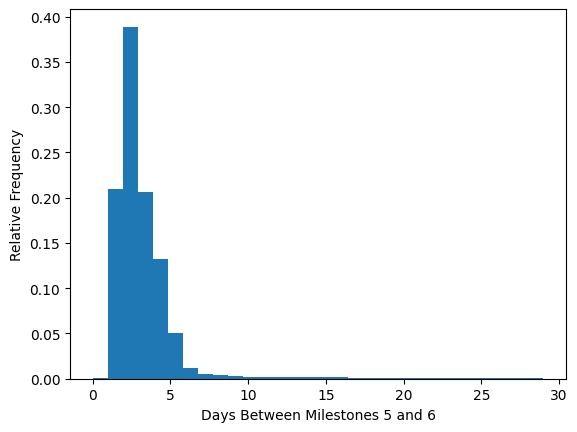

In [82]:
# Distribution of time between milestones 5 and 6 when the time frame is less than 1 month
# I include this restriction because the distribution is highly skewed to the right
plt.hist(times_between_milestones_5_and_6[times_between_milestones_5_and_6 < 30], bins=30, density=True)
plt.xlabel('Days Between Milestones 5 and 6')
plt.ylabel('Relative Frequency')
plt.show()

In [ ]:
# {time to milestone 5} / {total time}
relative_times_to_milestone_5 = np.array([(journey_timestamps[np.where(journey_events == 27)][0] - journey_timestamps[0]) / (journey_timestamps[-1] - journey_timestamps[0]) for journey_timestamps, journey_events in zip(includes5['timestamps'], includes5['events'])])

In [92]:
relative_times_to_milestone_5[0]

np.float64(0.6464257214374868)

In [93]:
np.median(relative_times_to_milestone_5)

np.float64(0.8554216867469879)

In [94]:
np.mean(relative_times_to_milestone_5)

np.float64(0.7465639032801593)

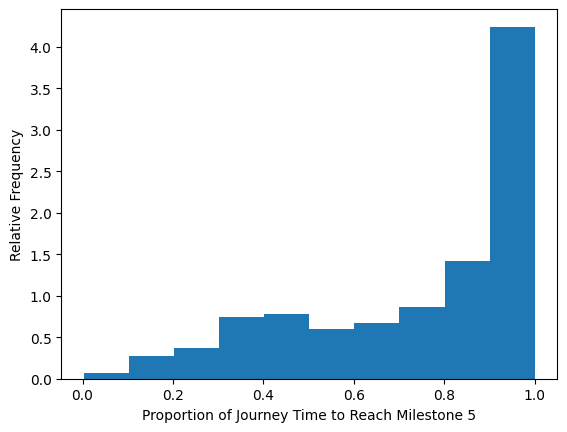

In [98]:
plt.hist(relative_times_to_milestone_5, density=True)
plt.xlabel('Proportion of Journey Time to Reach Milestone 5')
plt.ylabel('Relative Frequency')
plt.show()

In [ ]:
includes4 = successfulJourneys[successfulJourneys['events'].apply(lambda x: 8 in x)]
time_to_first_milestone_4 = np.array([((journey_timestamps[np.where(journey_events == 8)][0] - journey_timestamps[0]) / np.timedelta64(1, 'D')).item() for journey_timestamps, journey_events in zip(includes4['timestamps'], includes4['events'])])

In [116]:
np.quantile(time_to_first_milestone_4, [0.1, 0.25, 0.5, 0.75, 0.9])

array([  0.43412037,   0.79877025,  10.94246528,  45.60023148,
       127.95838079])

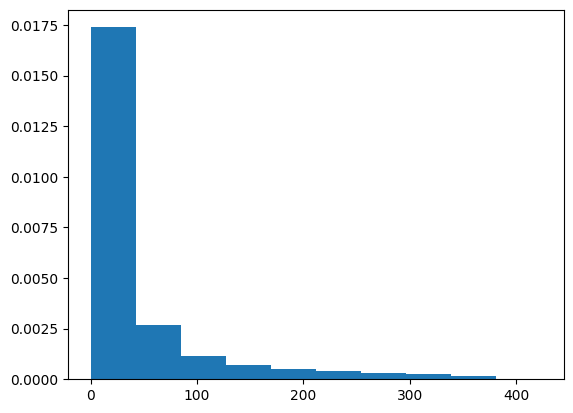

In [114]:
plt.hist(time_to_first_milestone_4, density=True)
plt.show()

In [118]:
includes4_unsuccessful = unsuccessfulJourneys[unsuccessfulJourneys['events'].apply(lambda x: 8 in x)]
time_to_first_milestone_4_unsuccessful = np.array([((journey_timestamps[np.where(journey_events == 8)][0] - journey_timestamps[0]) / np.timedelta64(1, 'D')).item() for journey_timestamps, journey_events in zip(includes4_unsuccessful['timestamps'], includes4_unsuccessful['events'])])

In [119]:
np.quantile(time_to_first_milestone_4_unsuccessful, [0.1, 0.25, 0.5, 0.75, 0.9])

array([  0.19588194,   0.64351273,   5.88105324,  39.31554398,
       125.07907639])

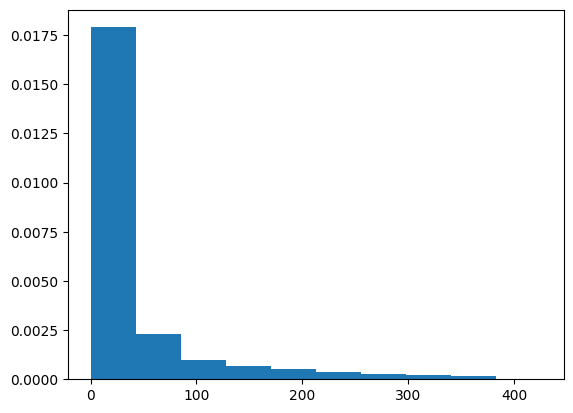

In [120]:
plt.hist(time_to_first_milestone_4_unsuccessful, density=True)
plt.show()

There is basically no difference in the distribution of time it takes successful and unsuccessful journeys to reach their first downpayment, so these type of unsuccessful journeys probably have very little to do with the person not being able to purchase a product. The unsuccessful result is likely due to factors other than financial capability.

In [136]:
# Percentage of unsuccessful journeys which placed a downpayment and clicked a campaign
100 * includes4_unsuccessful[includes4_unsuccessful['events'].apply(lambda x: 2 in x)].shape[0] / includes4_unsuccessful.shape[0]

57.15597734578295

In [137]:
# Percentage of unsuccessful journeys whose downpayment was cleared
100 * includes4_unsuccessful[includes4_unsuccessful['events'].apply(lambda x: 27 in x)].shape[0] / includes4_unsuccessful.shape[0]

43.32363896117149

In [144]:
includes4_unsuccessful['journey_length'].describe()

count    19599.000000
mean        69.619470
std         62.853226
min          7.000000
25%         32.000000
50%         52.000000
75%         85.000000
max       1208.000000
Name: journey_length, dtype: float64

In [153]:
journey_times_includes4_unsuccessful = np.array([((timestamps[-1] - timestamps[0]) / np.timedelta64(1, 'D')).item() for timestamps in includes4_unsuccessful['timestamps']])

In [155]:
np.quantile(journey_times_includes4_unsuccessful, [0.1, 0.25, 0.5, 0.75, 0.9])

array([  2.        ,  14.47764468,  65.95543981, 204.72922454,
       282.68360648])

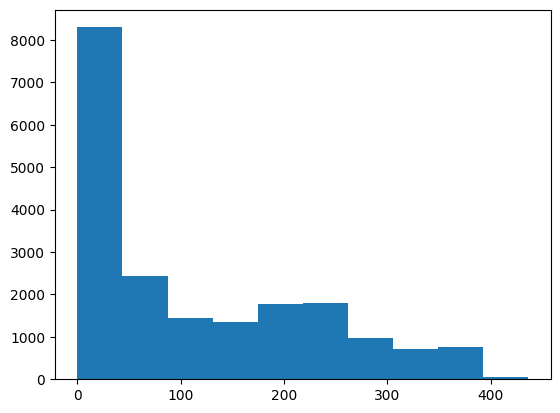

In [156]:
plt.hist(journey_times_includes4_unsuccessful)
plt.show()